# Instructions

As in the previous assignment, youl'll be using PyTorch instead of EDF. This assignment will focus on generative modelling, and you'll implement and train a VAE and a GAN.

It is highly suggested to use google colab and run the notebook on a GPU node.
Check https://colab.research.google.com/ and look for tutorials online on how to use it. To use a GPU go to Runtime -> Change runtime type and select GPU.

In [1]:
%matplotlib inline
import torch, math, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from scipy.stats import kde
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(0)
#torch.set_deterministic(True)
np.random.seed(0)

In this second part of the assignment you'll train a VAE and a GAN on a more interesting dataset. The cell below will try to download and load CelebA, and will just load MNIST in case there is an error.

It is likely that you'll get an error when trying to download CelebA since the its google drive is always out of quota. If you'd like to use CelebA anyway, you can try to download it from here http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html or some other source. If you're not running this notebook on a GPU then use MNIST instead.

## VAE and GANs on CelebA/MNIST

In [4]:
N_IN_CHANNELS = 1 # graymap
N_CLASSES = 10
BATCH_SIZE = 32
IMG_SIZE = 64

In [5]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE), 
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))])

In [6]:
dataset = datasets.MNIST("data", train=True, download=True, transform=transform)

In [7]:
LABELS = torch.LongTensor(range(N_CLASSES)).cuda()
LABELS_ONEHOT = F.one_hot(LABELS, N_CLASSES)

In [8]:
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# from google.colab.patches import cv2_imshow
import cv2

def show(x):
    img = x.data.cpu().permute(1, 2, 0).numpy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # cv2_imshow(img)
    plt.figure()
    plt.imshow(img)
    plt.show()

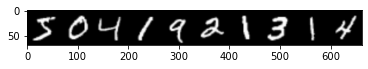

In [10]:
data = [dataset[i][0] for i in range(10)]
grid_img = torchvision.utils.make_grid(data, nrow=10, normalize=True)
show(grid_img)

We'll use a a CNN for the VAE instead of the simple model we defined previously.
Implement a network following these specifications:

- Encoder. Should have 4 conv layers, each with kernel size 4, stride 2 and padding 1, which decrease the spatial resolution by half. The output of the 4th conv (a spatial res. 4x4) should be flattened and then fully connected layers should be used to compute mu and logvar. Add whichever activation function you prefer between the conv layers (ReLU, LeakyReLU, ELU, etc), and feel free to add batch norm as well. Let the first conv layer have, say, 8 or 16 channels and then double the number of channels at each following conv layer.

- Decoder. Try to have an architecture that is roughly symmetric to the encoder. For example, start with a fully connected layer to project the latent_dim dimensional input such that you end up with a (128x4x4)-dimensional vector that you can reshape into a 4x4 image. Then you can apply 4 transposed conv layers, e.g. with kernel size 4, stride 2 and padding 1, to double the spatial resolution with each layer, having a final output of size 64x64. Start with around 64 or 128 channels for the first transposed conv and then halve the number of channels at each following conv layer. As before, add your preferred activation function between layers, with or without batch norm.

The encode, sample, and decode methods have the same specification as before.

The cell below applies a 'patch' in case you're using google colab (cv2_imshow doesn't work properly on google colab without it). Feel free to comment out the first import if you're not using google colab (you might have to add from cv2 import cv2_imshow, though).

Again, try to find a value for beta that yields reasonable results.

You'll also re-implement the Generator and Discriminator modules for the GAN, adopting a CNN-like architecture.

For the generator, implement a network similar to the one you used for the VAE decoder (fully connected for projection followed by 4 transposed convolutions), while for the discriminator you should use a network similar to the VAE encoder (4 conv layers with stride 2, but note that the output should be a scalar per image, not a latent vector).

In [23]:
class ConditionalConvGenerator(nn.Module):
    def __init__(self, latent_dim, n_in_channels, n_classes, img_size):
        """
        assume img has same height and width
        """
        super(ConditionalConvGenerator, self).__init__()
        self.latent_dim = latent_dim

        n_channels = 16 # tuneable hyperparam
        self.n_channels = n_channels
        self.emb_size = 128
        self.flat_dim = n_channels * 8 * 4 * 4
        
        # to embed noise
        self.emb = nn.Embedding(n_classes, self.emb_size)
        self.decoder_fc = nn.Linear(latent_dim + self.emb_size, self.flat_dim)
        self.network = nn.Sequential(
            nn.ConvTranspose2d(n_channels * 8, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels * 4, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels * 2, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(n_channels, n_in_channels, 4, 2, 1)
        )
    
    def decode(self, input):
        # implementation goes here
        out = self.decoder_fc(input) 
        out = out.reshape(-1, self.n_channels * 8, 4, 4)
        out = self.network(out)
        return out

    def forward(self, n, y):
        """
        y must be scalar labels
        """
        z = torch.randn(n, self.latent_dim).cuda()
        embed = self.emb(y)
        z = torch.cat((z, embed), dim=1)
        samples = self.decode(z)
        return samples

In [28]:
class ConditionalConvDiscriminator(nn.Module):
    def __init__(self, latent_dim, n_in_channels, n_classes, img_size):
        super(ConditionalConvDiscriminator, self).__init__()
        self.latent_dim = latent_dim

        n_channels = 16
        self.n_channels = n_channels
        self.flat_dim = n_channels * 8 * 4 * 4
        self.n_in_channels = n_in_channels
        
        # to embed class labels
        self.emb = nn.Embedding(n_classes, img_size * img_size)
        self.network = nn.Sequential(
            # one more channel from label
            nn.Conv2d(n_in_channels + 1, n_channels, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels, n_channels * 2, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 2, n_channels * 4, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(n_channels * 4, n_channels * 8, 4, 2, 1),
            nn.Flatten(),
            nn.Linear(self.flat_dim, 1) # scalar output
            # no need for sigmoid as we are using BCEWithLogitsLoss
        )
    
    def forward(self, x, y):
        # implementation goes here
        embed = self.emb(y).view(y.shape[0], 1, x.shape[-2], x.shape[-1])
        x = torch.cat((x, embed), dim=1)
        out = self.network(x)
        return out

In [32]:
generator = ConditionalConvGenerator(100, N_IN_CHANNELS, N_CLASSES, IMG_SIZE).cuda()
gopt = torch.optim.Adam(generator.parameters(), lr=5e-4, betas=(0.5, 0.999))
discriminator = ConditionalConvDiscriminator(100, N_IN_CHANNELS, N_CLASSES, IMG_SIZE).cuda()
dopt = torch.optim.Adam(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999))
criterion = torch.nn.BCEWithLogitsLoss()

generator loss 0.7035627365112305, discriminator loss 1.3895983695983887


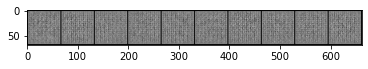

generator loss 3.6590747833251953, discriminator loss 0.16635039448738098


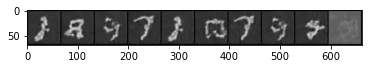

KeyboardInterrupt: 

In [33]:
BATCH_SIZE = 32
for epoch in range(30):
    for i, (x, y) in enumerate(loader):
        real_x = x.cuda()
        real_y = y.cuda()
        fake_x = generator(BATCH_SIZE, real_y).cuda()
        fake_y = torch.LongTensor(torch.randint(0, N_CLASSES, size=(BATCH_SIZE,))).cuda()
        
        disc_labels_real = torch.ones((BATCH_SIZE,), dtype=torch.float).cuda()
        disc_labels_fake = torch.zeros((BATCH_SIZE,), dtype=torch.float).cuda()

        # Train G
        # tell discriminator these are real data
        preds_fake = discriminator(fake_x, real_y).squeeze().cuda()
        gloss = criterion(preds_fake, disc_labels_real)
        gopt.zero_grad()
        gloss.backward()
        gopt.step()

        # Train D to tell if the labelled images are fake
        # real
        preds_real = discriminator(real_x, real_y).squeeze().cuda()
        dloss = criterion(preds_real, disc_labels_real)    
        # fake, detach so grad doesn't go into generator
        preds_fake = discriminator(fake_x.detach(), fake_y).squeeze().cuda()
        dloss += criterion(preds_fake, disc_labels_fake)
        dopt.zero_grad()
        dloss.backward()
        dopt.step()
        
        if i == 0:
            print('generator loss {}, discriminator loss {}'.format(gloss.item(), dloss.item()))
            data = generator(10, LABELS)
            grid_img = torchvision.utils.make_grid(data, nrow=10, normalize=True)
            show(grid_img)